<a href="https://colab.research.google.com/github/suleymanerpak/Car-Price-Prediction-with-GA/blob/main/Car_Price_Prediction_with_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# Gerekli kütüphaneleri içe aktar
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive
drive.mount('/content/drive')

# Dosya yolu
file_path = "/content/drive/MyDrive/Colab Notebooks/veri_detayli.csv"


# Veriyi oku
df = pd.read_csv(file_path)

# Önizleme
print("Veri ön izlemesi:")
print(df.head())

# Sütunlar
print("Sütunlar:")
print(df.columns)

# Yinelenenleri sil
df = df.drop_duplicates()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Veri ön izlemesi:
        Title  Price (TL)             Location Transmission  Horsepower (hp)  \
0       title         NaN                  NaN          NaN              NaN   
1  375.000 TL       375.0         Tokat, Erbaa     Otomatik              NaN   
2  342.500 TL       342.5      Bursa, Yıldırım     Otomatik             90.0   
3  435.000 TL       435.0   İstanbul, Esenyurt          Düz             90.0   
4  200.000 TL       200.0  Ankara, Yenimahalle     Otomatik              NaN   

      Color    Model  Engine Capacity (cc)     Fuel Type  Painted Parts Count  \
0       NaN      NaN                   NaN           NaN                  NaN   
1     Beyaz      NaN                   NaN  LPG & Benzin                  NaN   
2  Şampanya  1.4 i S                1396.0  LPG & Benzin                  NaN   
3       Gri  1.4 i S                1396.0  LPG 

In [33]:
# İlgisiz ve çok eksik verileri içeren sütunları kaldır
df = df.drop(columns=["Title", "Model", "Painted Parts Count", "Changed Parts Count"], errors="ignore")

# Hedef sütun ve önemli kategorik sütunlarda eksik varsa satırı sil
df = df.dropna(subset=["Price (TL)", "Location", "Transmission", "Color", "Fuel Type"])

# Sayısal sütunlardaki eksikleri medyan ile doldur
for col in ["Horsepower (hp)", "Engine Capacity (cc)"]:
    df[col] = df[col].fillna(df[col].median())

# Kategorik sütunları one-hot encode et
df = pd.get_dummies(df, columns=["Location", "Transmission", "Color", "Fuel Type"], drop_first=True)

# Bağımsız değişkenleri (X) ve hedef değişkeni (y) ayır
X = df.drop("Price (TL)", axis=1)
y = df["Price (TL)"]

# Eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Veri hazırlandı.")

Veri hazırlandı.


In [34]:
# Genetik algoritma parametreleri
population_size = 15
generations = 10
mutation_rate = 0.1
num_features = X_train.shape[1]

# Rastgele birey oluştur (özellikleri 0 veya 1 olarak seçer)
def create_individual():
    return [random.randint(0, 1) for _ in range(num_features)]

# Rastgele popülasyon oluştur
def create_population():
    return [create_individual() for _ in range(population_size)]

# Bir bireyin başarısını (fitness) MSE ile hesapla
def fitness(ind):
    idx = [i for i, bit in enumerate(ind) if bit == 1]
    if not idx:
        return float("inf")
    model = LinearRegression()
    model.fit(X_train.iloc[:, idx], y_train)
    pred = model.predict(X_test.iloc[:, idx])
    return mean_squared_error(y_test, pred)

# En iyi bireyleri seç
def selection(pop):
    scored = [(ind, fitness(ind)) for ind in pop]
    scored.sort(key=lambda x: x[1])
    return [x[0] for x in scored[:5]]

# Çaprazlama işlemi
def crossover(p1, p2):
    point = random.randint(1, len(p1)-1)
    return p1[:point] + p2[point:]

# Mutasyon işlemi
def mutate(ind):
    return [bit if random.random() > mutation_rate else 1 - bit for bit in ind]

In [35]:
# Genetik algoritmayı başlat (erken durdurmalı)
population = create_population()
best_individual = None
best_score = float("inf")

no_improve_count = 0
patience = 10  # 10 nesil boyunca iyileşme olmazsa algoritma duracak

# Evrim süreci
for gen in range(generations):
    selected = selection(population)
    new_pop = selected.copy()
    while len(new_pop) < population_size:
        p1, p2 = random.sample(selected, 2)
        child = mutate(crossover(p1, p2))
        new_pop.append(child)

    population = new_pop
    improved = False

    for ind in new_pop:
        score = fitness(ind)
        if score < best_score:
            best_score = score
            best_individual = ind
            improved = True

    if improved:
        no_improve_count = 0
    else:
        no_improve_count += 1

    print(f"🧬 Nesil {gen+1} tamamlandı - En iyi MSE: {best_score:.2f}")

    if no_improve_count >= patience:
        print(f"⏹ Durduruldu: {patience} nesildir iyileşme yok.")
        break

🧬 Nesil 1 tamamlandı - En iyi MSE: 25553.20
🧬 Nesil 2 tamamlandı - En iyi MSE: 25243.28
🧬 Nesil 3 tamamlandı - En iyi MSE: 24915.34
🧬 Nesil 4 tamamlandı - En iyi MSE: 24915.34
🧬 Nesil 5 tamamlandı - En iyi MSE: 24534.98
🧬 Nesil 6 tamamlandı - En iyi MSE: 24220.97
🧬 Nesil 7 tamamlandı - En iyi MSE: 23803.43
🧬 Nesil 8 tamamlandı - En iyi MSE: 23725.89
🧬 Nesil 9 tamamlandı - En iyi MSE: 23725.89
🧬 Nesil 10 tamamlandı - En iyi MSE: 23507.20


In [36]:
# En iyi bireyin seçtiği özellikler
selected_idx = [i for i, b in enumerate(best_individual) if b == 1]
selected_features = X_train.columns[selected_idx]

# Lineer regresyon modelini eğit
final_model = LinearRegression()
final_model.fit(X_train.iloc[:, selected_idx], y_train)

# Test seti tahminleri ve performans metrikleri
y_pred = final_model.predict(X_test.iloc[:, selected_idx])
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Sonuçları yazdır
print("✅ Seçilen Özellikler:", list(selected_features))
print("📉 Katsayılar:", final_model.coef_)
print("🎯 Bias (intercept):", final_model.intercept_)
print("📈 Test RMSE:", rmse)
print("📊 Test R²:", r2)

✅ Seçilen Özellikler: ['Horsepower (hp)', 'Location_Adana, Kozan', 'Location_Adana, Sarıçam', 'Location_Adana, Çukurova', 'Location_Adıyaman, Besni', 'Location_Adıyaman, Merkez', 'Location_Afyonkarahisar, Başmakçı', 'Location_Afyonkarahisar, Dinar', 'Location_Afyonkarahisar, Merkez', 'Location_Afyonkarahisar, Çay', 'Location_Aksaray, Merkez', 'Location_Amasya, Merkez', 'Location_Amasya, Merzifon', 'Location_Amasya, Suluova', 'Location_Ankara, Beypazarı', 'Location_Ankara, Etimesgut', 'Location_Ankara, Gölbaşı', 'Location_Ankara, Mamak', 'Location_Ankara, Sincan', 'Location_Ankara, Yenimahalle', 'Location_Antalya, Aksu', 'Location_Antalya, Alanya', 'Location_Antalya, Kepez', 'Location_Antalya, Konyaaltı', 'Location_Antalya, Kumluca', 'Location_Antalya, Serik', 'Location_Aydın, Efeler', 'Location_Aydın, Germencik', 'Location_Aydın, Kuyucak', 'Location_Aydın, Söke', 'Location_Aydın, Yenipazar', 'Location_Aydın, İncirliova', 'Location_Ağrı, Patnos', 'Location_Balıkesir, Bigadiç', 'Location

In [37]:
# 📦 Bu fonksiyon, kullanıcıdan alınan ilan özellikleriyle tahmin yapar.
# Modelin eğitildiği özelliklere göre sütunları oluşturur ve eksik olanları sıfırla tamamlar.

def ilan_tahmin_et(model, özellikler, değerler, feature_names):
    """
    model         : Eğitilmiş Lineer Regresyon modeli
    özellikler    : Modelin seçtiği özellik isimleri listesi
    değerler      : Kullanıcının girdiği ilan verisi (dict)
    feature_names : Tüm one-hot encoded sütunlar (X_train.columns)

    return        : Tahmin edilen fiyat (float)
    """
    # Tüm sütunlara sahip sıfırdan bir veri satırı oluştur
    df_ilan = pd.DataFrame([0]*len(feature_names), index=feature_names).T

    # Kullanıcının girdiği değerleri ilgili sütunlara yerleştir
    for key, val in değerler.items():
        if key in df_ilan.columns:
            df_ilan[key] = val

    # Sadece modelin seçtiği özelliklerle tahmin yap
    X_input = df_ilan[özellikler]

    # Model tahmini döndür
    return model.predict(X_input)[0]

In [38]:
# Kullanıcının girdiği özelliklerle eşleşen satırdan gerçek fiyatı bul
def gercek_fiyat_bul(degerler, df_original):
    """
    degerler: {"Feature_Adı": değer, ...}
    df_original: one-hot encoded dataframe
    """
    df_filtered = df_original.copy()
    for key, val in degerler.items():
        if key in df_filtered.columns:
            df_filtered = df_filtered[df_filtered[key] == val]
    if not df_filtered.empty:
        return df_filtered["Price (TL)"].values[0]  # ilk eşleşen
    else:
        return None

In [39]:
# Kullanıcıdan alınan örnek ilan verisi
ornek_veri = {
    "Horsepower (hp)": 90,
    "Location_Ankara, Keçiören": 1,
    "Transmission_Otomatik": 0,
    "Color_Gri": 1,
    "Fuel Type_LPG & Benzin": 1
}

# Tahmin yap
tahmin = ilan_tahmin_et(final_model, list(selected_features), ornek_veri, list(X_train.columns))

# Gerçek fiyatı bul
gercek_fiyat = gercek_fiyat_bul(ornek_veri, df)

# Sonuçları karşılaştır
print("🔮 Tahmin Edilen Fiyat:", round(tahmin, 2), "TL")
if gercek_fiyat:
    print("✅ Gerçek Fiyat:", round(gercek_fiyat, 2), "TL")
    print("🎯 Hata Payı:", round(abs(tahmin - gercek_fiyat), 2), "TL")
else:
    print("❌ Gerçek fiyat bulunamadı. Girilen değerlere tam eşleşen satır yok.")

🔮 Tahmin Edilen Fiyat: 323.15 TL
✅ Gerçek Fiyat: 325.0 TL
🎯 Hata Payı: 1.85 TL


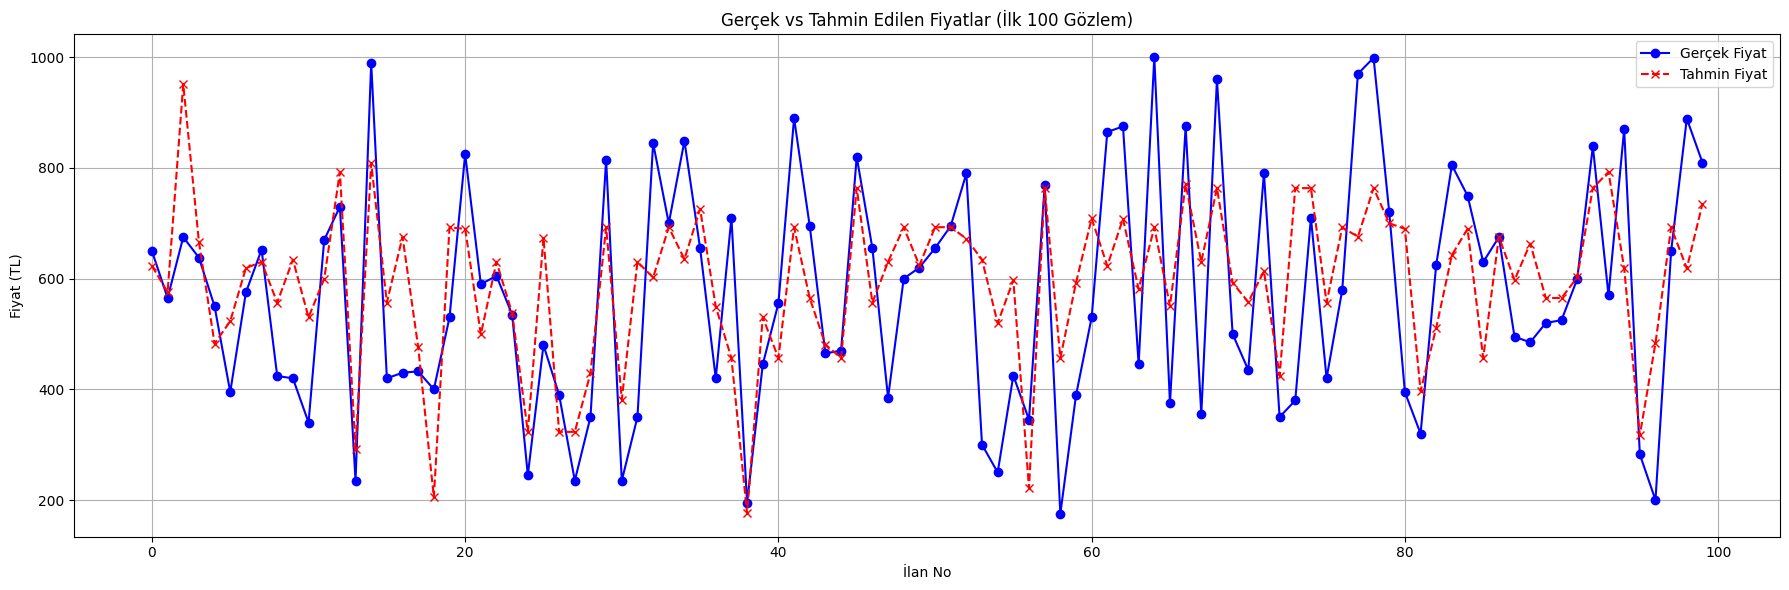

In [40]:
import matplotlib.pyplot as plt

# İlk 100 gözlemi al
n = 100
y_true_sample = y_test.iloc[:n].values
y_pred_sample = final_model.predict(X_test.iloc[:n, selected_idx])

# Grafik çizimi
plt.figure(figsize=(18, 6))
plt.plot(y_true_sample, label='Gerçek Fiyat', marker='o', linestyle='-', color='blue')
plt.plot(y_pred_sample, label='Tahmin Fiyat', marker='x', linestyle='--', color='red')
plt.title('Gerçek vs Tahmin Edilen Fiyatlar (İlk 100 Gözlem)')
plt.xlabel('İlan No')
plt.ylabel('Fiyat (TL)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()